# Problem 2

## Part A - Choose the Architecture
### Hidden layer:

1D Input → use shallow network (1–2 hidden layers)

2D or more dimension input → may need deeper network

### Node number:

Smooth, simple function→ small width (16–32)

Oscillatory / curved function→ moderate width (32–64)

Very complex function → larger width or extra layer

For this question, I choose 1 hidden layer and 32 nodes

## Part B - Choose Activation Function
### Hidden layers: 

use ReLU as a good first choice (remember, it's just a good default, not a mandatory one).

### Output layer:

Regression (predict a real number, e.g., stock price differences): use Linear output.

Regression (predict a non-negative number, e.g., heights): use ReLU output. A special case of this is - predicting values between 0 and 1, say Probabilities - use Sigmoid output.

Binary classification (yes/no): use Sigmoid output (one node).

Multi-class classification (one of many classes): use Softmax (not covered yet in class) - don’t use a single sigmoid for this.

### My answer:
Hidden layer: ReLU

output layer: Linear

## Part C - Choose Loss Function



![Loss Function](loss_function.png)

based on this rule, I choose MSE

## Part D - Training process

## Import the data

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('hw7_p2_data.csv', header = None)

# By default, Pandas assumes the first row of your CSV contains column names (like "X" and "Y"). 
# Because your CSV doesn't have headers, Pandas is treating your very first data point as the column names

## Split data into two columns 

In [3]:
x = df.iloc[:, 0].to_numpy()

In [4]:
y = df.iloc[:, 1].to_numpy()

## Nomralize the data

In [5]:
x_normalized = (x - x.mean()) / x.std()
y_normalized = (y - y.mean()) / y.std()

In [6]:
x_normalized.shape

(100,)

## Convert data into tensor

In [7]:
import torch

In [8]:
x_t = torch.tensor(x_normalized, dtype=torch.float32).view(-1, 1)
y_t = torch.tensor(y_normalized, dtype=torch.float32).view(-1, 1)

# Convert the normalized data into a 2-dimensional float tensor that the neural network can read and process.

## Dataset & Dataloader

In [9]:
from torch.utils.data import TensorDataset, DataLoader

In [10]:
dataset = TensorDataset(x_t, y_t)
# Combine input tensor (x_t) and target tensor (y_t) into a dataset
# Each sample becomes a pair: (x, y)


loader = DataLoader(dataset, batch_size=32, shuffle=True)
# shuffle the order of pairs of data in the dataset and then splist the dataset into mini-batches
# 99 data & 32 batch --> batch1 32 pairs of data, batch2 32 pairs of data
# batch3 32 pairs of data, batch4 3 pairs of data


# A small dataset generally means fewer than 10,000 samples, 
# while fewer than 1,000 samples is considered very small. 
# dataset with 99 samples is considered very small or tiny.
# For small datasets, it is recommended to use smaller batch sizes such as 8, 16, or 32.
# In general, smaller datasets prefer smaller batches, and larger datasets can handle larger batch sizes.

## Model

In [11]:
import torch.nn as nn

In [12]:
model = nn.Sequential(     # generate the NNs
    nn.Linear(1, 32),      # the first hidden layer with 32 neurons (you choose the num of neurons before)
    nn.ReLU(),             # activation function (activation functions introduce non-linearity into the model)
    nn.Linear(32, 1)       # the output layer 
)

## Loss & Optimizer

In [13]:
loss_fn = nn.MSELoss()    # measures how far the model’s predictions are from the true values
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
# uses the gradient of that loss to update the model’s parameters so the loss decreases over time.

# There are many optimizers. You may want to learn how to choose the loss_f and optimizers

## Training Loop

In [14]:
epochs = 1000   # how many times the model sees the entire dataset

# we have 4 mini-batch, 
# how many times the model can see the data: num_of_epochs * 4

for epoch in range(epochs):       # run epochs times 
    for xinl, yinl in loader:     # use those two data (tensor type) from the loader
        # Forward pass (model makes prediction)
        forw = model(xinl)

        # compute loss (measure prediction error)
        loss = loss_fn(forw, yinl)   # MSEloss b/c you choose loss_fn = nn.MSELoss()
        # loss is the loss of only the current mini-batch.

        # Backward pass (compute gradients to know How much the loss will change if we change this weight)
        optimizer.zero_grad()     # clears (resets) all previously stored gradients
                                  # (e.g. clean the GD from 1th loop for 2nd loop)
        loss.backward()  # computes the gradients of the lossfpr each edge using backpropagation.

        # Update weights (Adjust weights to reduce loss actomatically by backward pass information)
        optimizer.step()     # Use the gradients that were just computed to update the model’s parameters

    if epoch % 150 == 0:   # Only run this every 150 epochs (0, 150, 300, 450, …).
        print (f"Epoch {epoch}, Loss: {loss.item()}")   

        # Loss.item() convert the tensor loss into a normal Python number for clean printing.
        # it print loss value (of the last mini-batch) every 150 epochs. NOT ACCUMULATIVE
        # e.g. EPOCH % 2 = 0 
        # if each eopch has 4 batches 
        # first epoch: 0.8,0.6,0.4,0.2 second epoch: 0.7,0.4,0.3,0.1. The result is 0.1

        # We print it to monitor training progress.
        # See whether the loss is decreasing (is the model learning?)
        # Detect problems early (loss exploding, not changing, NaN, etc.)
        # Check if training has converged (loss stops improving)


Epoch 0, Loss: 2.178217649459839
Epoch 150, Loss: 0.4445664882659912
Epoch 300, Loss: 0.22068236768245697
Epoch 450, Loss: 0.43591368198394775
Epoch 600, Loss: 0.5575864911079407
Epoch 750, Loss: 0.1958087533712387
Epoch 900, Loss: 0.07738984376192093


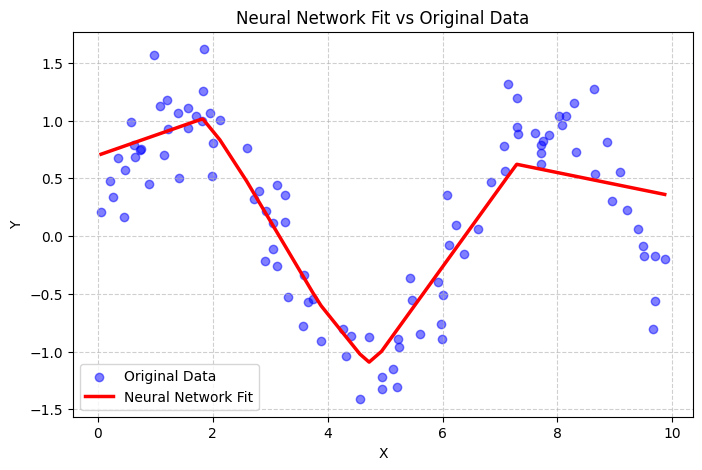

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Put the model in evaluation mode (good practice)
model.eval()

# 2. Get predictions from the trained model
# We use torch.no_grad() because we don't need to calculate gradients for plotting
with torch.no_grad():
    predictions_normalized = model(x_t).numpy()

# 3. Un-normalize the predictions back to the original scale
# Formula: original = (normalized * standard_deviation) + mean
predictions = (predictions_normalized * y.std()) + y.mean()

# 4. Sort the x values and predictions so the line plots smoothly
# If we don't sort, the line will zig-zag wildly connecting points in random order
sorted_indices = np.argsort(x)
x_sorted = x[sorted_indices]
predictions_sorted = predictions[sorted_indices]

# 5. Plot the results
plt.figure(figsize=(8, 5))

# Plot the original raw data as blue dots
plt.scatter(x, y, label='Original Data', color='blue', alpha=0.5)

# Plot the model's predictions as a red line
plt.plot(x_sorted, predictions_sorted, label='Neural Network Fit', color='red', linewidth=2.5)

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Neural Network Fit vs Original Data')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# Part E - Plot Empirical Risk

In [17]:
epochs = 1000
losses = []  # one value per epoch

for epoch in range(epochs):

    epoch_loss = 0.0  # reset each epoch

    for xin1, yin1 in loader:
        pred = model(xin1)
        loss = loss_fn(pred, yin1)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()  # add batch loss as a number

    epoch_loss /= len(loader)      # average over batches
    losses.append(epoch_loss)      # store ONE number per epoch

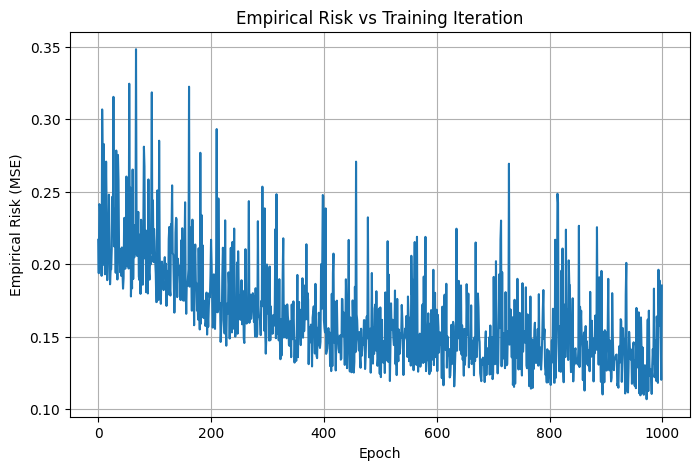

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Empirical Risk (MSE)")
plt.title("Empirical Risk vs Training Iteration")
plt.grid(True)
plt.show()

# Problem 3

## Takeaway:
### (1) A neural network is just a parameterized function. H(x,w)

![Neural network is func](Neural_network_is_func.png)

### (2) Backpropagation is just the chain rule
### derivative of output × derivative of activation × derivative of linear layer

### (3)Training = optimizing a loss function

### You are not optimizing the network output.
### You are optimizing: R(w) = average squared error

### (4) Neural network training is non-convex
### Some initializations work. Some don’t
### Learning rate matters
### Convergence is not guaranteed

## Part A - Build up the forward pass by numpy instead of torch

In [19]:
df = pd.read_csv('hw7_p2_data.csv')

In [20]:
def Relu(t):
    return np.maximum(0, t)

def H(x, w):
    w = np.asarray(w, dtype=float)

    # unpack w
    W100, W101, b10, b11, W200, W210, b20 = w

    # hidden layer pre-activations
    z1 = W100 * x + b10
    z2 = W101 * x + b11

    # hidden layer activations (ReLU)
    a1 = Relu(z1)
    a2 = Relu(z2)

    # output layer (linear)
    out = W200 * a1 + W210 * a2 + b20
    return out

## Part B - backprop by numpy instead of torch

In [ ]:
def del_H(x, w):
    """
    Returns grad of H(x, w) w.r.t. w as a numpy array of length 7.
    w = (W100, W101, b10, b11, W200, W210, b20)
    """
    w = np.asarray(w, dtype=float)
    W100, W101, b10, b11, W200, W210, b20 = w

    # ----- forward -----
    z1 = W100 * x + b10
    z2 = W101 * x + b11
    a1 = Relu(z1)
    a2 = Relu(z2)
    # H = W200*a1 + W210*a2 + b20  (linear output)

    # ----- backward -----
    # dH/da
    dH_da1 = W200
    dH_da2 = W210

    # ReLU' (use z>0)
    da1_dz1 = 1.0 if z1 > 0 else 0.0
    da2_dz2 = 1.0 if z2 > 0 else 0.0

    # dH/dz
    dH_dz1 = dH_da1 * da1_dz1
    dH_dz2 = dH_da2 * da2_dz2

    # grads for first layer params
    dH_dW100 = dH_dz1 * x
    dH_dW101 = dH_dz2 * x
    dH_db10  = dH_dz1
    dH_db11  = dH_dz2

    # grads for second layer params + output bias
    dH_dW200 = a1
    dH_dW210 = a2
    dH_db20  = 1.0

    return np.array([dH_dW100, dH_dW101, dH_db10, dH_db11, dH_dW200, dH_dW210, dH_db20], dtype=float)

# quick check for the input in the prompt:
x = 5
w = (1, 2, -1, -2, 3, 4, -5)
g = del_H(x, w)
print(g)          # should start with 15
print(g.sum())    # should be 55

[15. 20.  3.  4.  4.  8.  1.]
55.0


# Part C - Turn the gradient from a single data point into the gradient over the entire dataset.

In [ ]:
# ---- Load data (x, y) ----
# Option A: if you downloaded data.csv locally:
# data = np.loadtxt("data.csv", delimiter=",")
# Option B: load directly from the URL (works if your environment allows internet):
data = np.loadtxt(
    "https://f000.backblazeb2.com/file/jeldridge-data/009-noisy_abs/data.csv",
    delimiter=","
)
X = data[:, 0]
Y = data[:, 1]

def del_R(w):
    """
    Gradient of empirical risk R(w) for square loss.
    Returns a numpy array of length 7.
    """
    w = np.asarray(w, dtype=float)
    n = X.shape[0]

    grad = np.zeros(7, dtype=float)
    for x_i, y_i in zip(X, Y):
        err = H(x_i, w) - y_i              # scalar
        grad += err * del_H(x_i, w)        # 7-vector

    grad *= (2.0 / n)
    return grad

# ---- compute the requested value ----
w_test = np.array([1, 2, -1, -2, 3, 4, -5], dtype=float)
g = del_R(w_test)
print(g)
print("sum:", g.sum())   # hint: should be around 2135

[603.6473778 804.8631704  81.70272   108.93696   173.9815526 347.9631052
  14.56888  ]
sum: 2135.6637659999997


## Part D 

seed=0 final_risk=6.270976
seed=1 final_risk=8.875822
seed=2 final_risk=1.849396
seed=3 final_risk=8.703693
seed=4 final_risk=3.703903
seed=5 final_risk=7.506176
seed=6 final_risk=4.546859
seed=7 final_risk=7.788077
seed=8 final_risk=8.205163
seed=9 final_risk=1.867551

Best seed=2 best_risk=1.849396


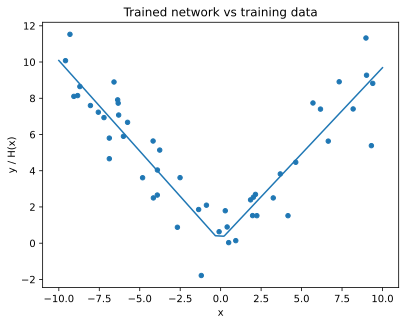

In [ ]:
def risk(w):
    """Empirical risk R(w) = mean squared error."""
    preds = np.array([H(xi, w) for xi in X], dtype=float)
    return np.mean((preds - Y) ** 2)

def gradient_descent(w_init, lr=1e-4, tol=1e-6, max_iter=20000, verbose=True):
    """
    Basic gradient descent on R(w) using del_R(w).
    Stops when ||w_new - w|| < tol or hits max_iter.
    Returns: w, risks(list)
    """
    w = np.asarray(w_init, dtype=float).copy()
    risks = []

    for it in range(max_iter):
        g = del_R(w)                  # ∇R(w), shape (7,)
        w_new = w - lr * g

        r = risk(w_new)
        risks.append(r)

        step_norm = np.linalg.norm(w_new - w)
        if verbose and (it % 200 == 0):
            print(f"iter={it:5d}  risk={r:.6f}  step_norm={step_norm:.6e}")

        w = w_new
        if step_norm < tol:
            if verbose:
                print(f"Converged at iter={it}, step_norm={step_norm:.6e}, risk={r:.6f}")
            break

    return w, risks

def train_with_restarts(seeds=(0, 1, 2, 3, 4), lr=1e-4, tol=1e-6, max_iter=20000):
    """
    Because it's non-convex, try several random initializations and keep the best.
    """
    best = None
    for s in seeds:
        np.random.seed(s)
        w_init = np.random.uniform(0, 1, 7)   # suggested style in prompt
        w, risks = gradient_descent(w_init, lr=lr, tol=tol, max_iter=max_iter, verbose=False)
        final_r = risks[-1] if len(risks) else risk(w)
        print(f"seed={s} final_risk={final_r:.6f}")

        if (best is None) or (final_r < best[0]):
            best = (final_r, s, w, risks)

    print(f"\nBest seed={best[1]} best_risk={best[0]:.6f}")
    return best[2], best[3]   # best_w, best_risks

# ---- run training ----
w_star, risks = train_with_restarts(
    seeds=range(10),   # try 10 starts
    lr=1e-4,           # you may need to tune this smaller/bigger
    tol=1e-6,
    max_iter=30000
)

# ---- plot H(x) over [-10, 10] with data ----
xs = np.linspace(-10, 10, 400)
ys = np.array([H(xi, w_star) for xi in xs], dtype=float)

plt.figure()
plt.scatter(X, Y, s=20)
plt.plot(xs, ys)
plt.xlabel("x")
plt.ylabel("y / H(x)")
plt.title("Trained network vs training data")
plt.show()